<a href="https://colab.research.google.com/github/lnsayer/personal_repo/blob/main/drug%20discovery%20with%20BACE%20dataset/graph_classification_bace_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installed rdkit, torch_geometric, deepchem, networkx, torchmetrics into google drive with pip. With this resource https://netraneupane.medium.com/how-to-install-libraries-permanently-in-google-colab-fb15a585d8a5
# This method ends up taking around 200s, whilst installing the libraries themselves takes around 100s which is more efficient.

In [2]:
from timeit import default_timer as timer

In [3]:
start_time = timer()
rd_kit_start_time = timer()
!pip install rdkit
rd_kit_end_time = timer()

torch_geometric_start_time = timer()
!pip install torch_geometric
torch_geometric_end_time = timer()

deep_chem_start_time = timer()
!pip install deepchem
deep_chem_end_time = timer()

networkx_start_time = timer()
!pip install networkx
networkx_end_time = timer()

end_time = timer()

print(f"Time for cell to run: {end_time-start_time:.4f}")
print(f"rd_kit time: {rd_kit_end_time-rd_kit_start_time:.4f}")
print(f"torch_geometric time: {torch_geometric_end_time-torch_geometric_start_time:.4f}")
print(f"deep_chem time: {deep_chem_end_time-deep_chem_start_time:.4f}")
print(f"networkx time: {networkx_end_time-networkx_start_time:.4f}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.7 MB/s eta 0:00:00
Time for cell to run: 25.6152
rd_kit time: 7.8377
torch_geometric time: 6.1281
deep_chem time: 6.7293
networkx time: 4.9199


In [4]:
# Import necessary modules
import requests
from pathlib import Path
import os.path as osp

from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv, GATConv, MLP, GINConv, global_max_pool, SAGPooling, TopKPooling, GINEConv
from torch.nn import Linear, ReLU, Dropout, Softmax
import torch.nn as nn
import torch.nn.functional as F

import deepchem as dc
from deepchem.feat.graph_data import GraphData

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from pandas import DataFrame

import networkx as nx

import random

from tqdm.auto import tqdm
from timeit import default_timer as timer

from IPython.display import Javascript
import pickle

import warnings

from typing import Callable, Optional, Any


warnings.filterwarnings("ignore", message="os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.")

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [5]:
# Show directory structure of my google drive

import os
google_drive_path = Path("drive/MyDrive")
# Prints all subdirectories (takes ages)
for dirpath, dirnames, filenames in os.walk(google_drive_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 9 directories and 27 files in 'drive/MyDrive'.
There are 3 directories and 103 files in 'drive/MyDrive/Peru 2019 Expedition'.
There are 1 directories and 0 files in 'drive/MyDrive/Peru 2019 Expedition/Alex's Photos'.
There are 0 directories and 418 files in 'drive/MyDrive/Peru 2019 Expedition/Alex's Photos/Peru 2019'.
There are 0 directories and 0 files in 'drive/MyDrive/Peru 2019 Expedition/Emilie'.
There are 0 directories and 0 files in 'drive/MyDrive/Peru 2019 Expedition/Groña'.
There are 0 directories and 2 files in 'drive/MyDrive/Private'.
There are 0 directories and 50 files in 'drive/MyDrive/Old phone photos'.
There are 0 directories and 37 files in 'drive/MyDrive/Go_pro_gorge_du_verdon_2016'.
There are 2 directories and 40 files in 'drive/MyDrive/Colab Notebooks'.
There are 0 directories and 1 files in 'drive/MyDrive/Colab Notebooks/__pycache__'.
There are 2 directories and 0 files in 'drive/MyDrive/Colab Notebooks/data'.
There are 0 directories and 1 files in 'drive

In [6]:
bace_project_path = google_drive_path / "bace_graph_project"
bace_raw_path = bace_project_path / "data/raw"

In [7]:
# Check if Bace csv file has been downloaded, if not, download it
if bace_raw_path.is_dir():
  print(f"{bace_raw_path} is already a directory")
else:
  print(f"{bace_raw_path} is not a directory, creating one")
  bace_raw_path.mkdir(parents=True, exist_ok=True)

  with open(bace_raw_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

drive/MyDrive/bace_graph_project/data/raw is already a directory


In [8]:
# If want to download bace csv straight into colab
data_path = Path("data/")
bace_path = data_path / "raw"

if bace_path.is_dir():
  print(f"{bace_path} is already a directory")
else:
  print(f"{bace_path} is not a directory, creating one")
  bace_path.mkdir(parents=True, exist_ok=True)

  with open(bace_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

data/raw is not a directory, creating one


In [9]:
bace_raw_path

PosixPath('drive/MyDrive/bace_graph_project/data/raw')

In [10]:
# Turn CSV file into a dataframe and resave it without unnecessary columns
bace_df = pd.read_csv(bace_raw_path/ "bace.csv")
bace_df = bace_df[["mol", "CID", "Class", "Model", "pIC50"]]
bace_df.to_csv(bace_raw_path/"bace.csv")

bace_df

,mol,CID,Class,Model,pIC50
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970
...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298


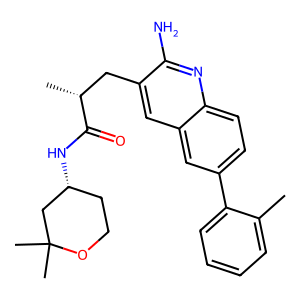

In [11]:
# Visualise one of the molecules from its SMILE input
inhibitor = bace_df["mol"][0]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

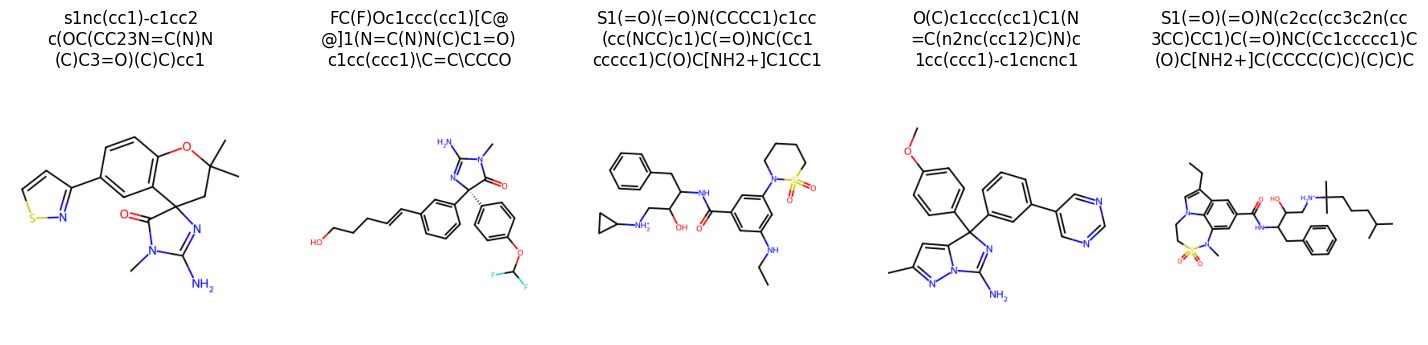

In [12]:
# Display five random molecules with their SMILES molecules

# Create axes and sample SMILES molecules
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (18,6))
mols = bace_df.sample(n=5, random_state=42)["mol"]

for i in range(len(mols)):

  # Convert each molecule to an image
  mol = mols.iloc[i]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  # Plot each molecule
  ax[i].imshow(img)
  ax[i].axis(False);

  # Divide the SMILE input into three parts
  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  # Title each plot with its respective SMILE input
  ax[i].set_title(first_title+second_title+third_title)

In [13]:
# Test converting a molecule into a graph using MolGraphConvFeaturizer and to_pyg_graph

# Select first molecule
mol = bace_df["mol"][1]

# Instantiate MolGraphConvFeaturizer class
featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

# Convert SMILES molecule into a DeepChem graph
out = featurizer.featurize(datapoints=mol)

# Convert into torch geometric graph
pyg_out = GraphData.to_pyg_graph(out[0])
pyg_out.y = torch.tensor([bace_df["Class"][0]])

print(pyg_out)

Data(x=[47, 30], edge_index=[2, 100], edge_attr=[100, 11], y=[1])


In [14]:
# Custom torch geometric Dataset class to store the samples and their corresponding labels

class MoleculeDataset(Dataset):
  def __init__(self, root, csv_file, transform=None, pre_transform=None, pre_filter=None):
    """
    root = Where the dataset should be stored. This folder is split
    into raw_dir (downloaded dataset) and processed_dir(processed data).
    """
    self.csv_file = csv_file
    super().__init__(root, transform, pre_transform, pre_filter)

  @property
  def raw_file_names(self):
    """
    If this file exists in raw_dir, the download is not triggered/
    (the download function is not implemented here)
    """
    return self.csv_file

  @property
  def processed_file_names(self):
    """
    If these files are found in raw_dir, processing is skipped
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()

    return [f'data_{i}.pt' for i in list(self.data.index)]

  def download(self):
    """
    No need to download the csv file as it is already downloaded
    """
    pass

  def process(self):
    """
    I used Deepchem's MolGraphConvFeaturizer to create a graph and then convert that to a torch graph with to_pyg_graph.
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()
    featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

    for idx, row in self.data.iterrows():
      # Featurize molecule and convert to torch graph
      smiles = row['mol']
      label = row['Class']
      pic50 = row['pIC50']

      out = featurizer.featurize(smiles)
      pyg_out = GraphData.to_pyg_graph(out[0])
      pyg_out.Class = torch.tensor([label])
      pyg_out.smiles = smiles
      pyg_out.pic50 = pic50

      # data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
      #            y=torch.tensor([label]), dtype = torch.float)

      torch.save(pyg_out, osp.join(self.processed_dir, f'data_{idx}.pt'))

  def len(self):
    """
    Returns number of samples in the dataset
    """
    return len(self.processed_file_names)

  def get(self, idx):
    """
    Loads a single graph
    """
    data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [15]:
# Instantiate the dataset from the BACE CSV file
start_time = timer()
# original_dataset = MoleculeDataset(root = "drive/MyDrive/bace_graph_project/data/", csv_file = "bace.csv").shuffle()
original_dataset = MoleculeDataset(root = "data/", csv_file = "bace.csv").shuffle()
dataset = original_dataset
end_time = timer()
print(f"Processing dataset took {end_time-start_time:.4f}s")

train_indices = int(0.8*len(dataset))

train_dataset = dataset[:train_indices]
test_dataset = dataset[train_indices:]


print(f"Total dataset samples: {len(dataset)}\nTrain dataset samples: {len(train_dataset)}\nTest dataset samples: {len(test_dataset)}")

Processing...
Done!


Processing dataset took 20.5860s
Total dataset samples: 1513
Train dataset samples: 1210
Test dataset samples: 303


In [16]:
# Calculate average nodes and edges in the graphs
avg_nodes = 0
avg_edges = 0
"""
for i in tqdm(range(len(original_dataset))):
  avg_nodes+=original_dataset[i].x.shape[0]
  avg_edges+=original_dataset[i].edge_index.shape[1]
avg_nodes = avg_nodes/len(original_dataset)
avg_edges = avg_edges/len(original_dataset)
print(f"avg nodes: {avg_nodes:.4f}, avg_edges: {avg_edges:.4f}")
"""
# Computation takes a long time, results:
print("avg nodes: 34.0892, avg_edges: 73.7184")

avg nodes: 34.0892, avg_edges: 73.7184


In [17]:
num_workers = 4
# Create a dataloader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

print(f"Number of batches: {len(train_dataloader)}")
print(f"Number of samples: {len(train_dataset)}")

Number of batches: 38
Number of samples: 1210


In [18]:
# Load a single graph

print(f"Number of nodes in graph is: {train_dataset[0].x.shape[0]}")
print(f"Number of features for each node is {train_dataset[0].num_features}")
print(f"Number of edges is {train_dataset[0].edge_index.shape[1]}")
print(f"Data object is {train_dataset[0]}\n")

Number of nodes in graph is: 25
Number of features for each node is 30
Number of edges is 56
Data object is Data(x=[25, 30], edge_index=[2, 56], edge_attr=[56, 11], Class=[1], smiles='O1c2c(cc(cc2)-c2ccccc2)C2(N=C(N)N(C)C2=O)CC1(C)C', pic50=6.3419886)



In [19]:
# Node features for one the graphs. This class is a featurizer of general graph convolution networks for molecules.
# The default node(atom) and edge(bond) representations are based on WeaveNet paper.

# train_dataset[0].x

In [20]:
# See the format for a batch
print(next(iter(train_dataloader)))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


DataBatch(x=[963, 30], edge_index=[2, 2104], edge_attr=[2104, 11], Class=[32], smiles=[32], pic50=[32], batch=[963], ptr=[33])


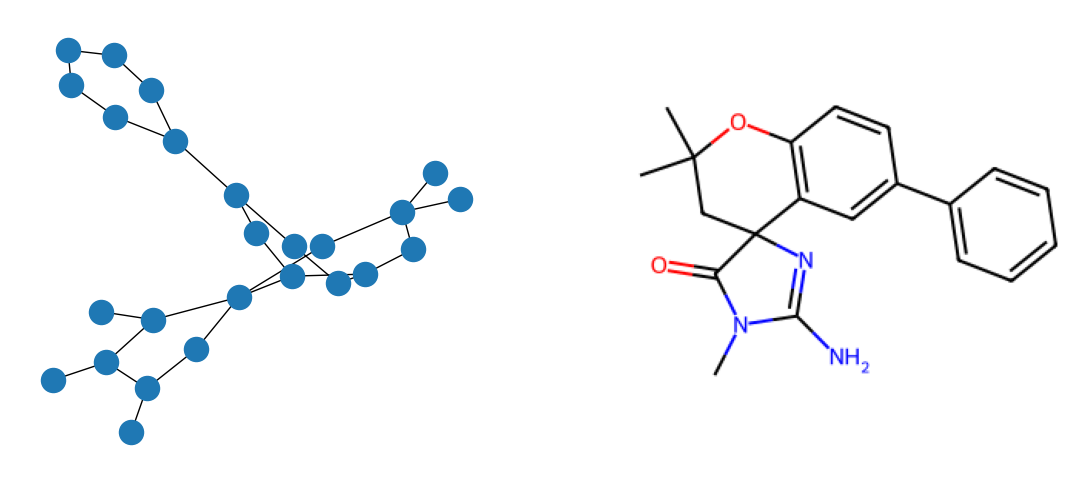

In [21]:
np.random.seed(44)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [22]:
# Print 5 batches
i = 0
for batch in train_dataloader:
  while i <5:
    print(i, batch)
    i+=1

0 DataBatch(x=[1026, 30], edge_index=[2, 2216], edge_attr=[2216, 11], Class=[32], smiles=[32], pic50=[32], batch=[1026], ptr=[33])
1 DataBatch(x=[1026, 30], edge_index=[2, 2216], edge_attr=[2216, 11], Class=[32], smiles=[32], pic50=[32], batch=[1026], ptr=[33])
2 DataBatch(x=[1026, 30], edge_index=[2, 2216], edge_attr=[2216, 11], Class=[32], smiles=[32], pic50=[32], batch=[1026], ptr=[33])
3 DataBatch(x=[1026, 30], edge_index=[2, 2216], edge_attr=[2216, 11], Class=[32], smiles=[32], pic50=[32], batch=[1026], ptr=[33])
4 DataBatch(x=[1026, 30], edge_index=[2, 2216], edge_attr=[2216, 11], Class=[32], smiles=[32], pic50=[32], batch=[1026], ptr=[33])


In [23]:
start_time = timer()
for idx, batch in enumerate(train_dataloader):
  pass
end_time = timer()
print(end_time-start_time)

0.5203028199999835


In [24]:
# Create tensor of the average of the node features for all 1210 training samples

a = torch.tensor(())
for idx, data in enumerate(train_dataloader):
  x = global_mean_pool(data.x, data.batch)
  a = torch.cat((a, x), 0)


In [25]:

print(a.shape)
df = pd.DataFrame(a.numpy())
# display(df)
corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')


torch.Size([1210, 30])


In [26]:
class GCNClassifier(torch.nn.Module):
  """
  Standard GCN graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, pool_method:torch_geometric.nn.pool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GCNConv(in_channels, hidden_channels)

    self.conv2 = GCNConv(hidden_channels, hidden_channels)

    self.conv3 = GCNConv(hidden_channels, hidden_channels)

    # Linear layer used in classification
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    x = self.conv1(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv2(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GCNClassifier(7, 64, 2, global_mean_pool)

GCNClassifier(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [27]:
class GraphConvClassifier(GCNClassifier):
  """
  Same architecture as GCN Classifier however use GraphConv layers
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int,  pool_method:torch_geometric.nn.pool):
    super().__init__(in_channels, hidden_channels, out_channels, pool_method)
    self.conv1 = GraphConv(in_channels, hidden_channels)

    self.conv2 = GraphConv(hidden_channels, hidden_channels)

    self.conv3 = GraphConv(hidden_channels, hidden_channels)
GraphConvClassifier(7, 64, 2, global_mean_pool)

GraphConvClassifier(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [28]:
class GATClassifier(torch.nn.Module):
  """
  GAT Convolutional graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, heads:int, pool_method:torch_geometric.nn.pool,
               use_edge_attr:bool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GATConv(in_channels,
                         hidden_channels,
                         heads,
                         concat = True)
    self.conv2 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         heads,
                         concat=True)
    self.conv3 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         1,
                         concat=False)
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    # can use edge attributes
    if use_edge_attr:
      x = self.conv1(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index, edge_attr)

    # not using edge attributes
    else:
      x = self.conv1(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GATClassifier(30, 64, 2, 8, global_max_pool, True)

GATClassifier(
  (conv1): GATConv(30, 64, heads=8)
  (conv2): GATConv(512, 64, heads=8)
  (conv3): GATConv(512, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [29]:
type(GINConv(nn))

torch_geometric.nn.conv.gin_conv.GINConv

In [30]:
class GINConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINConv

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    for conv in self.convs:
      x = conv(x, edge_index).relu()
    x = pool_method(x, batch)
    return self.mlp(x)

GINConvClassifier(30, 64, 2, 3, global_mean_pool)

GINConvClassifier(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(30, 64, 64))
    (1-2): 2 x GINConv(nn=MLP(64, 64, 64))
  )
  (mlp): MLP(64, 64, 2)
)

In [31]:
class GINEConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool,
               use_edge_attr:bool, edge_dim:int):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINEConv
    self.use_edge_attr = use_edge_attr
    self.edge_dim = edge_dim

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False, edge_dim=self.edge_dim))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr
    for conv in self.convs:
      if self.use_edge_attr:
        x = conv(x, edge_index, edge_attr).relu()
      else:
        x = conv(x, edge_index).relu()

    x = pool_method(x, batch)
    return self.mlp(x)

GINEConvClassifier(30, 64, 2, 3, global_mean_pool, True, dataset[0].edge_attr.shape[1])

GINEConvClassifier(
  (convs): ModuleList(
    (0): GINEConv(nn=MLP(30, 64, 64))
    (1-2): 2 x GINEConv(nn=MLP(64, 64, 64))
  )
  (mlp): MLP(64, 64, 2)
)

In [32]:
dataset[2].edge_attr.shape[1]

11

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  """
  Performs the training of a model for one epoch for the training dataloader.

  Returns lists of the training loss, accuracy and AUC of the training dataloader for the epoch.
  """

  model.to(device)
  model.train()

  train_loss, train_acc, train_auc = 0, 0, 0

  # We time how long it takes for each section in the training process
  auc_time = 0
  out_time = 0
  loss_time = 0
  optimizer_time = 0
  section_time = 0
  dataloader_loop_time = 0
  inside_loop_time = 0


  loop_start_time = timer()

  # Loop over the batches
  for idx, batch in enumerate(dataloader):
    # print(f"entered {idx} loop of train step")
    inside_loop_start_time = timer()
    # Time how long it takes to obtain an idx and batch of the dataloader
    if idx > 1:
      dataloader_loop_end_time = timer()
      dataloader_loop_time += dataloader_loop_end_time-dataloader_loop_start_time

    # Can time how long any chosen section takes to run
    section_start_time = timer()
    to_device_start_time = timer()
    batch = batch.to(device)
    to_device_end_time = timer()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Forward pass
    out_start_time = timer()
    out = model(batch)
    out_end_time = timer()
    out_time+=out_end_time-out_start_time

    # Calculate the loss
    loss = loss_fn(out, batch.Class)
    train_loss += loss.item()

    # Calculate the label predictions
    label_preds = torch.argmax(out, dim=1)
    # Calculate accuracy
    train_acc += (label_preds == batch.Class).sum()

    # Calculate AUC
    auc_start_time = timer()
    # Check both classes present in batch.Class, otherwise add the batch_auc from the previous iteration
    if len(torch.unique(batch.Class)) == 2:
        batch_auc = roc_auc_score(batch.Class.detach().cpu().numpy(), out[:,1].detach().cpu().numpy())
        train_auc += batch_auc
    else:
      train_auc += batch_auc

    auc_end_time = timer()
    auc_time += auc_end_time-auc_start_time


    # Loss backward
    loss_start_time = timer()
    loss.backward()
    loss_end_time = timer()
    loss_time += loss_end_time-loss_start_time

    # Optimizer step
    optimizer_start_time = timer()
    optimizer.step()
    optimizer_end_time = timer()
    optimizer_time = optimizer_end_time-optimizer_start_time
    section_end_time = timer()
    section_time+=section_end_time-section_start_time
    dataloader_loop_start_time = timer()
    inside_loop_end_time = timer()
    inside_loop_time += inside_loop_end_time-inside_loop_start_time


  loop_end_time = timer()
  # print(f"Section time is {section_time:.4f}")
  # print(f"Dataloader loop time is {dataloader_loop_time:.4f}")

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader.dataset)
  train_acc = train_acc/len(dataloader.dataset)
  train_auc = train_auc/len(dataloader)
  # print(f"AUC calculation time: {auc_time:.4f}s, Forward pass: {out_time:.4f}s, Loss time: {loss_time:.4f}, Optimizer time: {optimizer_time:.4f}, To device time: {to_device_end_time-to_device_start_time:.4f}\n")


  #print(f"Train outside loop time is {loop_end_time-loop_start_time:.4f}, inside loop time is {inside_loop_time:.4f}")

  return train_loss, train_acc, train_auc

In [51]:
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):

  """
  Performs the testing of a model for one epoch for the test dataloader.

  Returns lists of the test loss, accuracy and AUC of the test dataloader for the epoch.
  """

  # Put model in eval mode
  model.eval()

  test_loss, test_acc, test_auc = 0, 0, 0

  # Turn on torch inference manager
  with torch.inference_mode():
    # Loop through data batches
    for idx, batch in enumerate(dataloader):
      # print(f"entered test step {idx} batch loop")
      batch = batch.to(device)

      # Forward pass
      out = model(batch)

      # Calculate the loss
      loss = loss_fn(out, batch.Class)
      test_loss += loss.item()

      # Calculate the label predictions
      label_preds = torch.argmax(out, dim=1)
      # Calculate accuracy
      test_acc += (label_preds == batch.Class).sum()/len(label_preds)

      # Calculate the AUC
      if len(torch.unique(batch.Class)) == 2:
        batch_auc = roc_auc_score(batch.Class.detach().cpu().numpy(), out[:,1].detach().cpu().numpy())
        test_auc += batch_auc
      else:
        test_auc += batch_auc


    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    test_auc = test_auc/len(dataloader)

    return test_loss, test_acc, test_auc

In [52]:
def moving_average(values, window_size):
    if len(values) < window_size:
        return None
    return sum(values[-window_size:]) / window_size

In [53]:
# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          device: torch.device,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int =5,
          model_save_path: str = None,
          window_size: int=10,
          patience: int=10):
  """
  Combines train_step and test_step to train a model and evaluate it at each epoch on the train_dataloader and test_dataloader.

  :model_save_path = a string used to save the model's parameters. If no string is provided it is not saved.

  Returns a dictionary of results.
  """


  # 1. Create empty results dictionary
  results = {"epoch": [],
             "train_loss": [],
             "train_acc": [],
             "train_auc": [],
             "test_loss": [],
             "test_acc": [],
             "test_auc": [],
             "saved_epochs": [],
             "test_loss_mov_avg": [],
             "test_auc_mov_avg": []}
  # 2. Loop through training and testing steps for a number of epochs
  best_moving_loss_avg = float('inf')
  best_moving_auc_avg = 0

  # Loop over the number of epochs
  for i in tqdm(range(epochs)):

    start_time = timer()
    train_step_start_time = timer()
    train_loss, train_acc, train_auc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer,
                                       device)
    train_step_end_time = timer()
    test_step_start_time = timer()
    test_loss, test_acc, test_auc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    optimizer,
                                    device)
    test_step_end_time = timer()
    # print(f"Train step time is {train_step_end_time-train_step_start_time:.4f}s, Test step time is {test_step_end_time-test_step_start_time:.4f}s\n")

    # 3. Print out what's happening
    print(f"Epoch: {i}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}, Test auc: {test_auc:.4f}")
    # 4. Update results dictionary
    append_start_time = timer()
    results["epoch"].append(i)
    results["train_loss"].append(round(train_loss, 4))
    results["train_acc"].append(round(train_acc.item(), 4))
    results["train_auc"].append(round(train_auc, 4))
    results["test_loss"].append(round(test_loss, 4))
    results["test_acc"].append(round(test_acc.item(), 4))
    results["test_auc"].append(round(test_auc, 4))
    append_end_time = timer()
    # print(f"append time is{append_end_time-append_start_time:.4f}")

    # 5. If model_save_path provided, save the model to its path based on whether test loss and test AUC have improved.
    """
    Once the number of epochs is greater than the window_size a current moving average is created of the last 'window_size'
    loss and AUC values. As long as these current metrics are higher than the current moving average, the model is saved.
    If the current metrics are not better than the current moving average for 'patience' epochs the training stops early.
    """

    save_timer_start = timer()
    if model_save_path:
      current_moving_loss_avg = moving_average(results["test_loss"], window_size)
      if current_moving_loss_avg is not None:
        results["test_loss_mov_avg"].append(round(current_moving_loss_avg, 4))
      else:
        results["test_loss_mov_avg"].append(None)


      current_moving_auc_avg = moving_average(results["test_auc"], window_size)
      if current_moving_auc_avg is not None:
        results["test_auc_mov_avg"].append(round(current_moving_auc_avg, 4))
      else:
        results["test_auc_mov_avg"].append(None)

      if current_moving_loss_avg is not None and current_moving_auc_avg is not None:
        if current_moving_loss_avg < best_moving_loss_avg and current_moving_auc_avg > best_moving_auc_avg:
          without_improvement_count = 0
          results["saved_epochs"].append(i)
          torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
                   f=model_save_path)
          print(f"Saved model at epoch {i} with current average test loss: {current_moving_loss_avg:.4f} and previous best: {best_moving_loss_avg:.4f}")
          print(f"Saved model at epoch {i} with current average AUC loss: {current_moving_auc_avg:.4f} and previous best: {best_moving_auc_avg:.4f}")
          best_moving_loss_avg = current_moving_loss_avg
          best_moving_auc_avg = current_moving_auc_avg

        else:
          without_improvement_count += 1
          print(f"Without_improvement_count: {without_improvement_count}")
        if without_improvement_count > patience:
          print("Early Stopping")
          break
    save_timer_end = timer()
    end_time  = timer()
    print(f"Epoch took {end_time-start_time:.2f} seconds")
    # print(f"Time to save loop : {save_timer_end-save_timer_start:.4f}")

  # 6. Return the filled results at the end of the epochs

  return results


In [54]:
# Create model directory in drive to save models into
print(f"bace_project path: {bace_project_path}")
bace_models_path = bace_project_path / "models"
print(f"bace_models_path: {bace_models_path}\n")

if bace_models_path.is_dir():
  print(f"{bace_models_path} is already a directory")
else:
  print(f"{bace_models_path} is not a directory, creating one")
  bace_models_path.mkdir(parents=True, exist_ok=True)

bace_project path: drive/MyDrive/bace_graph_project
bace_models_path: drive/MyDrive/bace_graph_project/models

drive/MyDrive/bace_graph_project/models is already a directory


In [55]:
# GCN Classifier Training Run
warnings.filterwarnings("ignore", category=RuntimeWarning)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
# with global mean pooling, best is around 100 epochs
nb_epochs = 300
pool_method = global_mean_pool
window_size = 10
patience = 30

# Instantiating GCN Classifier
model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sgd_optimizer = torch.optim.SGD(model.parameters())
criterion = torch.nn.CrossEntropyLoss()



bace_gcn_models_path = bace_models_path / "gcn_models"


if bace_gcn_models_path.is_dir():
  print(f"{bace_gcn_models_path} is already a directory")
else:
  print(f"{bace_gcn_models_path} is not a directory, creating one")
  bace_gcn_models_path.mkdir(parents=True, exist_ok=True)

"""
results = train(model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""


<IPython.core.display.Javascript object>

drive/MyDrive/bace_graph_project/models/gcn_models is already a directory


'\nresults = train(model,\n      train_dataloader,\n      test_dataloader,\n      adam_optimizer,\n      loss_fn = criterion,\n      epochs = nb_epochs)\n'

In [39]:
print(bace_models_path)

drive/MyDrive/bace_graph_project/models


In [41]:
def run_model_repeats(model: torch.nn.Module,
                      device: torch.device,
                      train_dataloader: torch.utils.data.DataLoader,
                      test_dataloader: torch.utils.data.DataLoader,
                      optimizer_: Callable[[], torch.optim.Optimizer],
                      criterion: torch.nn.Module,
                      models_directory: Path=None,
                      num_hidden_channels: int = 128,
                      pool_method: Any = global_mean_pool,
                      nb_epochs: int = 300,
                      nb_repeats: int = 1,
                      window_size: int = 10,
                      patience: int = 50):
  """
  Runs training runs for 'nb_repeats' and optionally saves them if nb_repeats.
  Optionally save the model and its results if models_directory provided.
  """

  for i in range(nb_repeats):
    if models_directory:
      model_save_name = f"{i}_{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}.pth"
      model_save_path  = models_directory / model_save_name
    else:
      model_save_path = None
    optimizer = optimizer_(model.parameters())


    results = train(model,
        device,
        train_dataloader,
        test_dataloader,
        optimizer,
        criterion,
        epochs = nb_epochs,
        model_save_path = model_save_path,
        window_size=window_size,
        patience=patience)
    if models_directory:
      with open(models_directory/f"{i}_{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_results.pkl", 'wb') as f:
        print("Saved results of this model")
        pickle.dump(results, f)
    else:
      print("Did not save results of this model")

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

criterion = torch.nn.CrossEntropyLoss()

def gcn_callable():
    return GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
def adam_optimizer_callable(parameters, lr=0.001, weight_decay=0):
    return torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

nb_repeats = 5
window_size = 10
patience = 30

model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)


"""
run_model_repeats(model = model,
                  optimizer_ = adam_optimizer_callable,
                  criterion_ = criterion,
                  nb_epochs = 2,
                  nb_repeats = 2)
"""

<IPython.core.display.Javascript object>

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0, Train loss: 0.0216, Train acc: 0.5471, Train AUC: 0.5565, Test loss: 0.6909, Test acc: 0.5248, Test auc: 0.5410
Epoch took 8.27 seconds


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1, Train loss: 0.0215, Train acc: 0.5397, Train AUC: 0.5691, Test loss: 0.6842, Test acc: 0.5494, Test auc: 0.5962
Epoch took 6.62 seconds
Did not save results of this model


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0, Train loss: 0.0213, Train acc: 0.5653, Train AUC: 0.6104, Test loss: 0.6803, Test acc: 0.5717, Test auc: 0.6354
Epoch took 2.98 seconds


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1, Train loss: 0.0211, Train acc: 0.5868, Train AUC: 0.6257, Test loss: 0.6851, Test acc: 0.5798, Test auc: 0.5968
Epoch took 3.81 seconds
Did not save results of this model


In [ ]:
print(out)

[GraphData(node_features=[47, 30], edge_index=[2, 100], edge_features=[100, 11])]


In [ ]:
# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
# with global mean pooling, best is around 100 epochs
nb_epochs = 300
pool_method = global_mean_pool

loaded_model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

bace_gcn_models_path = bace_models_path / "gcn_models"


if bace_gcn_models_path.is_dir():
  print(f"{bace_gcn_models_path} is already a directory")
else:
  print(f"{bace_gcn_models_path} is not a directory, creating one")
  bace_gcn_models_path.mkdir(parents=True, exist_ok=True)

# Load a random model
model_save_path = bace_gcn_models_path/"0_128_250_global_mean_pool.pth"

print(model_save_path)
loaded_model.load_state_dict(torch.load(f=model_save_path))

loaded_model.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model(next(iter(test_dataloader)))
# loaded_model_preds

drive/MyDrive/bace_graph_project/models/gcn_models is already a directory
drive/MyDrive/bace_graph_project/models/gcn_models/0_128_250_global_mean_pool.pth


In [ ]:
# Function which gives the AUC of a model and its metrics, as given by Scikit-Learn's classification report

def new_metric_func(model, train_dataloader, test_dataloader):
  with torch.inference_mode():
    model.eval()

    # Create empty tensors to fill with probabilities, predictions and labels
    total_train_probs = torch.empty(len(train_dataset))
    total_train_preds = torch.empty(len(train_dataset))
    total_train_labels = torch.empty(len(train_dataset))

    total_test_probs = torch.empty(len(test_dataset))
    total_test_preds = torch.empty(len(test_dataset))
    total_test_labels = torch.empty(len(test_dataset))

    # Loop over batches and add to the total tensors
    for idx, batch in enumerate(train_dataloader):
      batch = batch.to(device)
      batch_size = 32
      current_batch_size = len(batch)
      # print(f"{idx*batch_size}:{idx*batch_size+current_batch_size}")
      out = model.forward(batch)
      train_probs = out[:,1]
      train_preds = torch.argmax(out, dim=1)

      total_train_probs[idx*batch_size:idx*batch_size+current_batch_size] = train_probs
      total_train_preds[idx*batch_size:idx*batch_size+current_batch_size] = train_preds
      total_train_labels[idx*batch_size:idx*batch_size+current_batch_size] = batch.Class

    for idx, batch in enumerate(test_dataloader):
      batch = batch.to(device)
      batch_size = 32
      current_batch_size = len(batch)
      # print(f"{idx*batch_size}:{idx*batch_size+current_batch_size}")
      out = model.forward(batch)
      test_probs = out[:,1]
      test_preds = torch.argmax(out, dim=1)

      total_test_probs[idx*batch_size:idx*batch_size+current_batch_size] = test_probs
      total_test_preds[idx*batch_size:idx*batch_size+current_batch_size] = test_preds
      total_test_labels[idx*batch_size:idx*batch_size+current_batch_size] = batch.Class

    # Calculate AUC and dataframes of metrics (using Scikit-Learn's metrics)
    train_auroc = roc_auc_score(total_train_labels, total_train_probs).item()
    train_classification_report = classification_report(total_train_labels, total_train_preds, output_dict=True)
    train_report_df = pd.DataFrame(data=train_classification_report).transpose()

    test_auroc = roc_auc_score(total_test_labels, total_test_probs).item()
    test_classification_report = classification_report(total_test_labels, total_test_preds, output_dict=True)
    test_report_df = pd.DataFrame(data=test_classification_report).transpose()


  return train_auroc, test_auroc, train_report_df, test_report_df


In [ ]:
torch.manual_seed(42)
loaded_model = loaded_model.to(device)
train_auroc, test_auroc, train_classification_report, test_classification_report = new_metric_func(loaded_model, train_dataloader, test_dataloader)
print(train_auroc, test_auroc)
display(train_classification_report, test_classification_report)

0.8520119340099983 0.805817610062893


,precision,recall,f1-score,support
0.0,0.878571,0.742081,0.804579,663.000000
1.0,0.736923,0.875686,0.800334,547.000000
accuracy,0.802479,0.802479,0.802479,0.802479
macro avg,0.807747,0.808884,0.802457,1210.000000
weighted avg,0.814537,0.802479,0.802660,1210.000000


,precision,recall,f1-score,support
0.0,0.802817,0.716981,0.757475,159.000000
1.0,0.720497,0.805556,0.760656,144.000000
accuracy,0.759076,0.759076,0.759076,0.759076
macro avg,0.761657,0.761268,0.759065,303.000000
weighted avg,0.763695,0.759076,0.758987,303.000000


In [ ]:
def average_model_metrics(model, models_directory, model_name_stem, repeats, save_yes_no):
  train_auroc_list = []
  test_auroc_list = []
  train_report_list = []
  test_report_list = []

  for i in range(repeats):
    model_name = f"{i}" + model_name_stem
    model_path = models_directory / model_name
    model.load_state_dict(torch.load(f=model_path))
    model.to(device)
    train_auroc, test_auroc, train_classification_report, test_classification_report = new_metric_func(model, train_dataloader, test_dataloader)
    train_auroc_list.append(train_auroc)
    test_auroc_list.append(test_auroc)
    train_report_list.append(pd.DataFrame(train_classification_report))
    test_report_list.append(pd.DataFrame(test_classification_report))

  mean_train_auroc = np.mean(train_auroc_list)
  mean_test_auroc = np.mean(test_auroc_list)

  std_train_auroc = np.std(train_auroc_list)
  std_test_auroc = np.std(test_auroc_list)

  auroc_data = {"Train": [mean_train_auroc, std_train_auroc],
               "Test": [mean_test_auroc, std_test_auroc]}
  auroc_df = pd.DataFrame(auroc_data)


  mean_train_model_metrics = pd.DataFrame(pd.concat(train_report_list).groupby(level=0).mean())
  mean_test_model_metrics = pd.DataFrame(pd.concat(test_report_list).groupby(level=0).mean())

  std_train_model_metrics = pd.DataFrame(pd.concat(train_report_list).groupby(level=0).std())
  std_test_model_metrics = pd.DataFrame(pd.concat(test_report_list).groupby(level=0).std())

  if save_yes_no:

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_auroc_df.pkl", 'wb') as f:
      print("Saved auroc dataframe")
      pickle.dump(auroc_df, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_mean_train_metrics.pkl", 'wb') as f:
      print("Saved mean train metrics")
      pickle.dump(mean_train_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_mean_test_metrics.pkl", 'wb') as f:
      print("Saved mean test metrics")
      pickle.dump(mean_test_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_std_train_metrics.pkl", 'wb') as f:
      print("Saved std train metrics")
      pickle.dump(std_train_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_std_test_metrics.pkl", 'wb') as f:
      print("Saved std test metrics")
      pickle.dump(std_test_model_metrics, f)


  return auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics

In [ ]:
gcn_model_skeleton = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
gat_model_skeleton = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, use_edge_attr)
graphconv_model_skeleton = GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
ginconv_model_skeleton = GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)


bace_gcn_models_path = bace_models_path / "gcn_models"
bace_gat_models_path = bace_models_path / "gat_models"
bace_graphconv_models_path = bace_models_path / "graphconv_models"
bace_ginconv_models_path = bace_models_path / "ginconv_models"

save_yes_no = False
auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics = average_model_metrics(ginconv_model_skeleton, bace_ginconv_models_path, "_128_300_global_mean_pool.pth", 5, save_yes_no)
display(auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics)

Saved auroc dataframe
Saved mean train metrics
Saved mean test metrics
Saved std train metrics
Saved std test metrics


,Train,Test
0,0.928965,0.873823
1,0.021335,0.012722


,precision,recall,f1-score,support
0.0,0.868711,0.849847,0.855849,654.000000
1.0,0.830430,0.838489,0.829465,556.000000
accuracy,0.844628,0.844628,0.844628,0.844628
macro avg,0.849571,0.844168,0.842657,1210.000000
weighted avg,0.851121,0.844628,0.843726,1210.000000


,precision,recall,f1-score,support
0.0,0.833301,0.795238,0.809322,168.000000
1.0,0.762982,0.789630,0.769133,135.000000
accuracy,0.792739,0.792739,0.792739,0.792739
macro avg,0.798141,0.792434,0.789227,303.000000
weighted avg,0.801971,0.792739,0.791416,303.000000


,precision,recall,f1-score,support
0.0,0.072126,0.058178,0.028933,0.00000
1.0,0.045134,0.112503,0.053063,0.00000
accuracy,0.036960,0.036960,0.036960,0.03696
macro avg,0.032638,0.041232,0.039442,0.00000
weighted avg,0.034788,0.036960,0.038436,0.00000


,precision,recall,f1-score,support
0.0,0.065117,0.075715,0.022852,0.000000
1.0,0.049063,0.120766,0.049562,0.000000
accuracy,0.026751,0.026751,0.026751,0.026751
macro avg,0.022923,0.033016,0.030655,0.000000
weighted avg,0.025660,0.026751,0.028998,0.000000


In [ ]:
/content/drive/MyDrive/bace_graph_project/models/gcn_models/0_128_300_global_mean_pool .pth

In [ ]:
start_time = timer()
train_auroc, test_auroc, train_report_df, test_report_df = new_metric_func(model, train_dataloader, test_dataloader)
end_time = timer()
print(round(end_time-start_time, 4))

5.5292


In [61]:
def loss_acc_auc_plots(results:dict):

  fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (15,6))

  ax[0].plot(results["epoch"], results["train_loss"], label="Train");
  ax[0].plot(results["epoch"], results["test_loss"],  label="Test");
  ax[0].vlines(results["saved_epochs"], ymin=0, ymax = max(results["test_loss"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')

  ax[1].plot(results["epoch"], results["train_acc"], label="Train");
  ax[1].plot(results["epoch"], results["test_acc"],  label="Test");
  ax[1].vlines(results["saved_epochs"], ymin=0, ymax = max(results["train_acc"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')


  ax[2].plot(results["epoch"], results["train_auc"], label="Train");
  ax[2].plot(results["epoch"], results["test_auc"],  label="Test");
  ax[2].vlines(results["saved_epochs"], ymin=0, ymax = max(results["train_auc"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')


  ax[0].set_xlabel("Epochs", size=14)
  ax[0].set_ylabel("Loss", size=14)

  ax[1].set_xlabel("Epochs", size=14)
  ax[1].set_ylabel("Accuracy", size=14)

  ax[2].set_xlabel("Epochs", size=14)
  ax[2].set_ylabel("AUC", size=14)

  ax[0].legend();
  ax[1].legend();
  ax[2].legend();

0
1
2
3
4


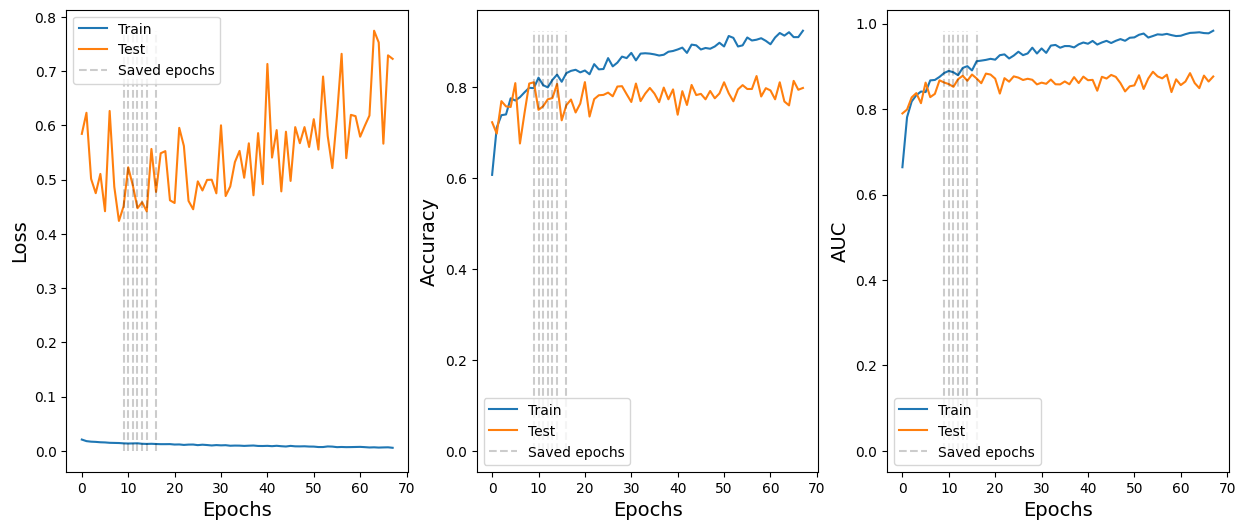

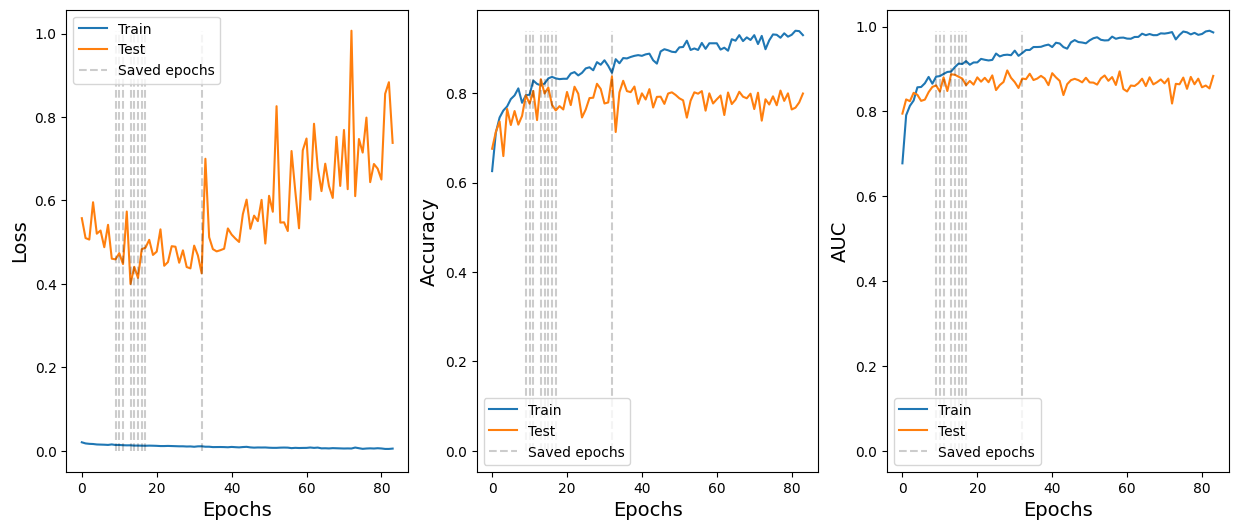

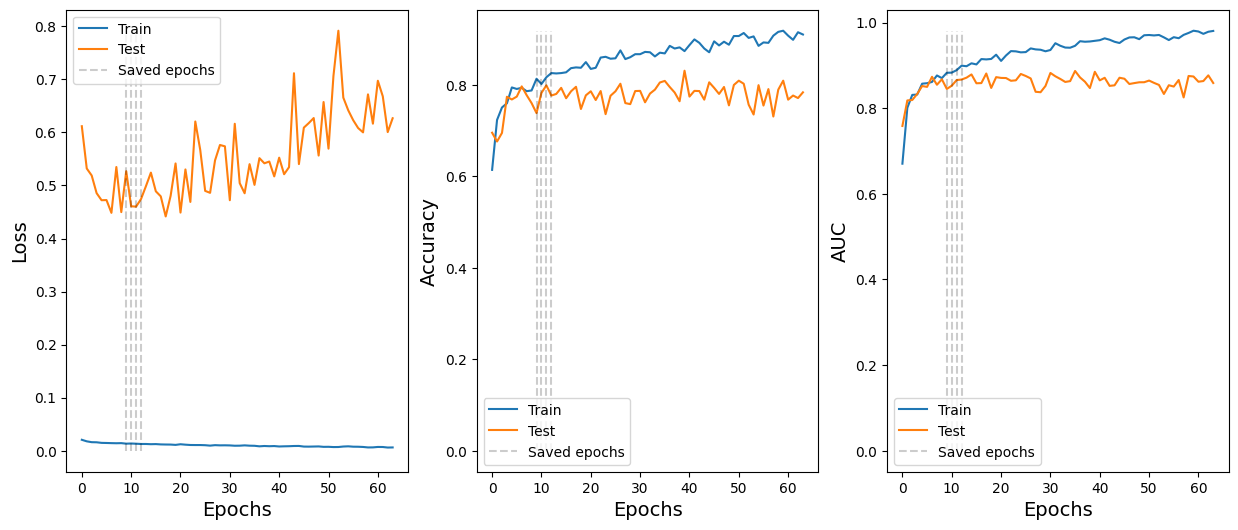

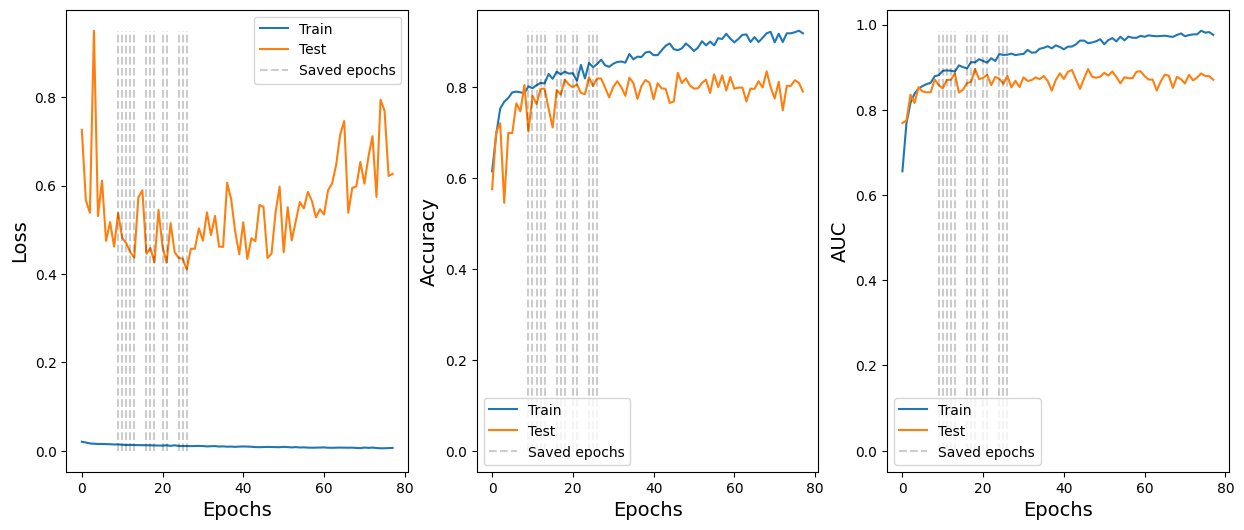

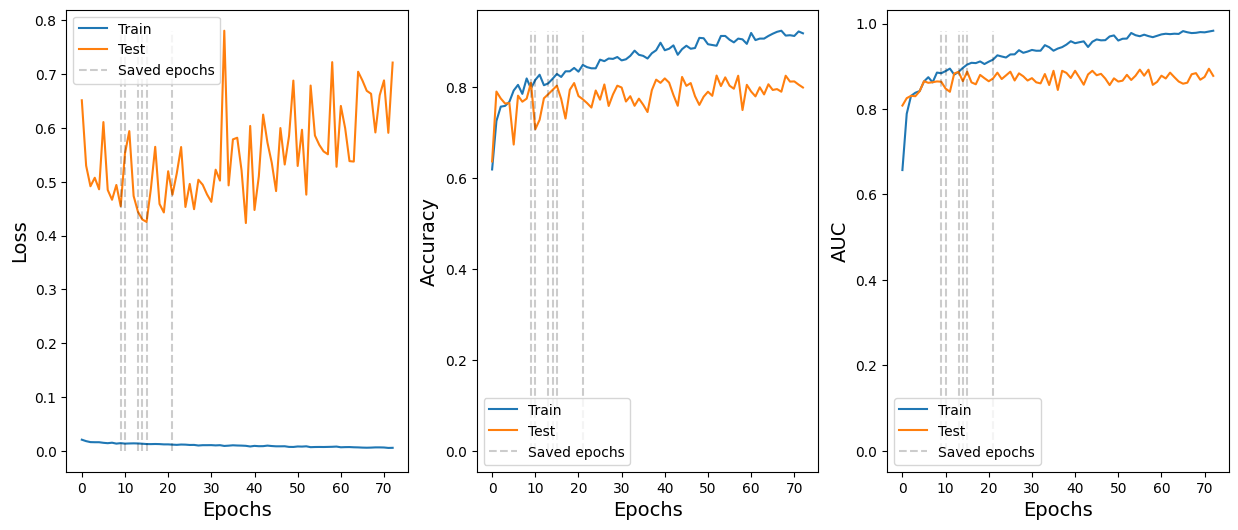

In [ ]:
for i in range(0,5):
  print(i)
  with open(f'/content/drive/MyDrive/bace_graph_project/models/ginconv_models/{i}_128_300_global_mean_pool_results.pkl', 'rb') as func:
      loaded_dict = pickle.load(func)

  loss_acc_auc_plots(loaded_dict)

In [ ]:
for key in loaded_dict:
   print(key)

print(loaded_dict["saved_epochs"])

epoch
train_loss
train_acc
train_auc
test_loss
test_acc
test_auc
saved_epochs
test_loss_mov_avg
test_auc_mov_avg
[9, 14, 22, 28, 35, 42, 57, 136]


In [ ]:
# GAT Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
heads=4
# with no edge attributes, global mean pooling best is 70 epochs
nb_epochs = 300
use_edge_attr = False
pool_method = global_mean_pool

# Instantiating GAT Classifier
gat_model = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, use_edge_attr)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(gat_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

"""
gat_results = train(gat_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""

bace_gat_models_path = bace_models_path / "gat_models"


if bace_gat_models_path.is_dir():
  print(f"{bace_gat_models_path} is already a directory")
else:
  print(f"{bace_gat_models_path} is not a directory, creating one")
  bace_gat_models_path.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

drive/MyDrive/bace_graph_project/models/gat_models is already a directory


In [47]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

criterion = torch.nn.CrossEntropyLoss()

def gat_callable():
    return GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, use_edge_attr)
def adam_optimizer_callable(parameters, lr=0.001, weight_decay=0):
    return torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
heads=4
# with no edge attributes, global mean pooling best is 70 epochs
nb_epochs = 300
use_edge_attr = False
pool_method = global_mean_pool
nb_repeats = 5
window_size = 10
patience = 50

# run_model_repeats(gat_callable, adam_optimizer_callable, criterion, bace_gat_models_path, num_hidden_channels, pool_method, nb_epochs, nb_repeats, window_size, patience)


<IPython.core.display.Javascript object>

In [ ]:
print(type(adam_optimizer))


In [ ]:
loss_and_acc_plots(gat_results)

In [ ]:
# GraphConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
# global mean pooling, best is 50 epochs
nb_epochs = 50
pool_method = global_mean_pool

# Instantiating GAT Classifier
graphconv_model = GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(graphconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(graphconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


bace_graphconv_models_path = bace_models_path / "graphconv_models"


if bace_graphconv_models_path.is_dir():
  print(f"{bace_graphconv_models_path} is already a directory")
else:
  print(f"{bace_graphconv_models_path} is not a directory, creating one")
  bace_graphconv_models_path.mkdir(parents=True, exist_ok=True)

"""
graphconv_results = train(graphconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""

<IPython.core.display.Javascript object>

drive/MyDrive/bace_graph_project/models/graphconv_models is not a directory, creating one


'\ngraphconv_results = train(graphconv_model,\n      train_dataloader,\n      test_dataloader,\n      adam_optimizer,\n      loss_fn = criterion,\n      epochs = nb_epochs)\n'

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

criterion = torch.nn.CrossEntropyLoss()

def graphconv_callable():
    return GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
def adam_optimizer_callable(parameters, lr=0.001, weight_decay=0):
    return torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
# with no edge attributes, global mean pooling best is 70 epochs
nb_epochs = 300
pool_method = global_mean_pool
nb_repeats = 5
window_size = 10
patience = 50

bace_graphconv_models_path = bace_models_path / "graphconv_models"

# run_model_repeats(graphconv_callable, adam_optimizer_callable, criterion, bace_graphconv_models_path, num_hidden_channels, pool_method, nb_epochs, nb_repeats, window_size, patience)


<IPython.core.display.Javascript object>

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0218, Train acc: 0.5331, Train AUC: 0.5406, Test loss: 0.6821, Test acc: 0.5467, Test auc: 0.5737
Epoch took 1.00 seconds
Epoch: 1, Train loss: 0.0213, Train acc: 0.5587, Train AUC: 0.6207, Test loss: 0.6671, Test acc: 0.5846, Test auc: 0.6448
Epoch took 0.95 seconds
Epoch: 2, Train loss: 0.0206, Train acc: 0.6248, Train AUC: 0.6964, Test loss: 0.6190, Test acc: 0.7019, Test auc: 0.7461
Epoch took 0.96 seconds
Epoch: 3, Train loss: 0.0195, Train acc: 0.6702, Train AUC: 0.7485, Test loss: 0.5911, Test acc: 0.7260, Test auc: 0.7829
Epoch took 0.96 seconds
Epoch: 4, Train loss: 0.0186, Train acc: 0.7050, Train AUC: 0.7919, Test loss: 0.5751, Test acc: 0.7225, Test auc: 0.8037
Epoch took 0.97 seconds
Epoch: 5, Train loss: 0.0181, Train acc: 0.7157, Train AUC: 0.8039, Test loss: 0.5817, Test acc: 0.7269, Test auc: 0.7978
Epoch took 0.95 seconds
Epoch: 6, Train loss: 0.0179, Train acc: 0.7322, Train AUC: 0.8034, Test loss: 0.5658, Test acc: 0.7163, Test auc: 0.8114
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0221, Train acc: 0.5190, Train AUC: 0.4984, Test loss: 0.6824, Test acc: 0.5529, Test auc: 0.5226
Epoch took 1.01 seconds
Epoch: 1, Train loss: 0.0216, Train acc: 0.5380, Train AUC: 0.6024, Test loss: 0.6595, Test acc: 0.6327, Test auc: 0.6691
Epoch took 1.00 seconds
Epoch: 2, Train loss: 0.0207, Train acc: 0.6207, Train AUC: 0.6723, Test loss: 0.6246, Test acc: 0.6831, Test auc: 0.7536
Epoch took 0.98 seconds
Epoch: 3, Train loss: 0.0198, Train acc: 0.6595, Train AUC: 0.7396, Test loss: 0.5997, Test acc: 0.6885, Test auc: 0.7415
Epoch took 1.00 seconds
Epoch: 4, Train loss: 0.0191, Train acc: 0.6843, Train AUC: 0.7655, Test loss: 0.6027, Test acc: 0.6952, Test auc: 0.7906
Epoch took 0.99 seconds
Epoch: 5, Train loss: 0.0184, Train acc: 0.7124, Train AUC: 0.7867, Test loss: 0.5642, Test acc: 0.7452, Test auc: 0.8061
Epoch took 1.01 seconds
Epoch: 6, Train loss: 0.0184, Train acc: 0.7132, Train AUC: 0.7987, Test loss: 0.5696, Test acc: 0.7202, Test auc: 0.8130
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0220, Train acc: 0.5289, Train AUC: 0.5572, Test loss: 0.6892, Test acc: 0.5185, Test auc: 0.5333
Epoch took 1.03 seconds
Epoch: 1, Train loss: 0.0218, Train acc: 0.5273, Train AUC: 0.5554, Test loss: 0.6789, Test acc: 0.5533, Test auc: 0.6508
Epoch took 1.03 seconds
Epoch: 2, Train loss: 0.0213, Train acc: 0.5702, Train AUC: 0.6622, Test loss: 0.6644, Test acc: 0.6854, Test auc: 0.7271
Epoch took 1.02 seconds
Epoch: 3, Train loss: 0.0206, Train acc: 0.6273, Train AUC: 0.7054, Test loss: 0.6486, Test acc: 0.6190, Test auc: 0.7622
Epoch took 1.03 seconds
Epoch: 4, Train loss: 0.0197, Train acc: 0.6545, Train AUC: 0.7365, Test loss: 0.6170, Test acc: 0.6644, Test auc: 0.7793
Epoch took 1.04 seconds
Epoch: 5, Train loss: 0.0192, Train acc: 0.6777, Train AUC: 0.7748, Test loss: 0.6431, Test acc: 0.6198, Test auc: 0.8122
Epoch took 1.09 seconds
Epoch: 6, Train loss: 0.0190, Train acc: 0.6893, Train AUC: 0.7843, Test loss: 0.5696, Test acc: 0.7421, Test auc: 0.8134
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0223, Train acc: 0.5174, Train AUC: 0.5286, Test loss: 0.6788, Test acc: 0.6015, Test auc: 0.6582
Epoch took 1.01 seconds
Epoch: 1, Train loss: 0.0213, Train acc: 0.5628, Train AUC: 0.6125, Test loss: 0.6548, Test acc: 0.6585, Test auc: 0.7087
Epoch took 1.02 seconds
Epoch: 2, Train loss: 0.0204, Train acc: 0.6264, Train AUC: 0.7214, Test loss: 0.6166, Test acc: 0.7171, Test auc: 0.7578
Epoch took 1.05 seconds
Epoch: 3, Train loss: 0.0195, Train acc: 0.6686, Train AUC: 0.7405, Test loss: 0.6030, Test acc: 0.7015, Test auc: 0.7868
Epoch took 1.03 seconds
Epoch: 4, Train loss: 0.0187, Train acc: 0.7033, Train AUC: 0.7819, Test loss: 0.5773, Test acc: 0.6948, Test auc: 0.8027
Epoch took 1.02 seconds
Epoch: 5, Train loss: 0.0179, Train acc: 0.7198, Train AUC: 0.8047, Test loss: 0.5584, Test acc: 0.7510, Test auc: 0.8183
Epoch took 1.06 seconds
Epoch: 6, Train loss: 0.0175, Train acc: 0.7413, Train AUC: 0.8173, Test loss: 0.5404, Test acc: 0.7719, Test auc: 0.8295
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0222, Train acc: 0.5116, Train AUC: 0.4883, Test loss: 0.6823, Test acc: 0.5694, Test auc: 0.5608
Epoch took 0.99 seconds
Epoch: 1, Train loss: 0.0211, Train acc: 0.5769, Train AUC: 0.6250, Test loss: 0.6519, Test acc: 0.6225, Test auc: 0.6657
Epoch took 0.99 seconds
Epoch: 2, Train loss: 0.0204, Train acc: 0.6215, Train AUC: 0.6859, Test loss: 0.6097, Test acc: 0.7265, Test auc: 0.7636
Epoch took 1.01 seconds
Epoch: 3, Train loss: 0.0197, Train acc: 0.6545, Train AUC: 0.7463, Test loss: 0.5915, Test acc: 0.7429, Test auc: 0.7792
Epoch took 1.00 seconds
Epoch: 4, Train loss: 0.0187, Train acc: 0.7099, Train AUC: 0.7703, Test loss: 0.5763, Test acc: 0.7398, Test auc: 0.7952
Epoch took 0.99 seconds
Epoch: 5, Train loss: 0.0182, Train acc: 0.7223, Train AUC: 0.8030, Test loss: 0.5827, Test acc: 0.7194, Test auc: 0.8217
Epoch took 1.05 seconds
Epoch: 6, Train loss: 0.0177, Train acc: 0.7355, Train AUC: 0.8124, Test loss: 0.5839, Test acc: 0.6925, Test auc: 0.8137
Ep

In [ ]:
# loss_and_acc_plots(graphconv_results)

In [ ]:
# GINConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
num_layers = 3
nb_epochs = 50
pool_method = global_mean_pool

# Instantiating GINConv Classifier
ginconv_model = GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(ginconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(ginconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

bace_ginconv_models_path = bace_models_path / "ginconv_models"

if bace_ginconv_models_path.is_dir():
  print(f"{bace_ginconv_models_path} is already a directory")
else:
  print(f"{bace_ginconv_models_path} is not a directory, creating one")
  bace_ginconv_models_path.mkdir(parents=True, exist_ok=True)

"""
ginconv_results = train(ginconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""


<IPython.core.display.Javascript object>

drive/MyDrive/bace_graph_project/models/ginconv_models is not a directory, creating one


'\nginconv_results = train(ginconv_model,\n      train_dataloader,\n      test_dataloader,\n      adam_optimizer,\n      loss_fn = criterion,\n      epochs = nb_epochs)\n'

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

criterion = torch.nn.CrossEntropyLoss()

def ginconv_callable():
    return GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)

def adam_optimizer_callable(parameters, lr=0.001, weight_decay=0):
    return torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
# with no edge attributes, global mean pooling best is 70 epochs
nb_epochs = 300
pool_method = global_mean_pool
nb_repeats = 5
window_size = 10
patience = 50

bace_ginconv_models_path = bace_models_path / "ginconv_models"

# run_model_repeats(ginconv_callable, adam_optimizer_callable, criterion, bace_ginconv_models_path, num_hidden_channels, pool_method, nb_epochs, nb_repeats, window_size, patience)


<IPython.core.display.Javascript object>

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0206, Train acc: 0.6074, Train AUC: 0.6639, Test loss: 0.5845, Test acc: 0.7233, Test auc: 0.7899
Epoch took 1.16 seconds
Epoch: 1, Train loss: 0.0177, Train acc: 0.7116, Train AUC: 0.7810, Test loss: 0.6234, Test acc: 0.6983, Test auc: 0.7990
Epoch took 1.08 seconds
Epoch: 2, Train loss: 0.0167, Train acc: 0.7388, Train AUC: 0.8180, Test loss: 0.5015, Test acc: 0.7698, Test auc: 0.8274
Epoch took 1.01 seconds
Epoch: 3, Train loss: 0.0163, Train acc: 0.7405, Train AUC: 0.8326, Test loss: 0.4751, Test acc: 0.7581, Test auc: 0.8375
Epoch took 1.01 seconds
Epoch: 4, Train loss: 0.0156, Train acc: 0.7760, Train AUC: 0.8412, Test loss: 0.5107, Test acc: 0.7569, Test auc: 0.8139
Epoch took 1.04 seconds
Epoch: 5, Train loss: 0.0153, Train acc: 0.7711, Train AUC: 0.8399, Test loss: 0.4418, Test acc: 0.8094, Test auc: 0.8621
Epoch took 1.03 seconds
Epoch: 6, Train loss: 0.0146, Train acc: 0.7785, Train AUC: 0.8673, Test loss: 0.6268, Test acc: 0.6765, Test auc: 0.8281
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0202, Train acc: 0.6256, Train AUC: 0.6775, Test loss: 0.5575, Test acc: 0.6756, Test auc: 0.7947
Epoch took 1.02 seconds
Epoch: 1, Train loss: 0.0175, Train acc: 0.7116, Train AUC: 0.7909, Test loss: 0.5098, Test acc: 0.7135, Test auc: 0.8282
Epoch took 1.15 seconds
Epoch: 2, Train loss: 0.0165, Train acc: 0.7455, Train AUC: 0.8130, Test loss: 0.5062, Test acc: 0.7367, Test auc: 0.8240
Epoch took 1.10 seconds
Epoch: 3, Train loss: 0.0161, Train acc: 0.7612, Train AUC: 0.8256, Test loss: 0.5957, Test acc: 0.6592, Test auc: 0.8438
Epoch took 1.06 seconds
Epoch: 4, Train loss: 0.0150, Train acc: 0.7702, Train AUC: 0.8567, Test loss: 0.5203, Test acc: 0.7648, Test auc: 0.8390
Epoch took 1.02 seconds
Epoch: 5, Train loss: 0.0147, Train acc: 0.7868, Train AUC: 0.8575, Test loss: 0.5279, Test acc: 0.7287, Test auc: 0.8247
Epoch took 1.03 seconds
Epoch: 6, Train loss: 0.0144, Train acc: 0.7950, Train AUC: 0.8662, Test loss: 0.4879, Test acc: 0.7600, Test auc: 0.8277
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0206, Train acc: 0.6140, Train AUC: 0.6703, Test loss: 0.6117, Test acc: 0.6952, Test auc: 0.7584
Epoch took 1.12 seconds
Epoch: 1, Train loss: 0.0177, Train acc: 0.7231, Train AUC: 0.8009, Test loss: 0.5320, Test acc: 0.6760, Test auc: 0.8180
Epoch took 1.03 seconds
Epoch: 2, Train loss: 0.0161, Train acc: 0.7504, Train AUC: 0.8309, Test loss: 0.5188, Test acc: 0.6948, Test auc: 0.8190
Epoch took 1.03 seconds
Epoch: 3, Train loss: 0.0159, Train acc: 0.7595, Train AUC: 0.8318, Test loss: 0.4855, Test acc: 0.7738, Test auc: 0.8332
Epoch took 1.02 seconds
Epoch: 4, Train loss: 0.0148, Train acc: 0.7942, Train AUC: 0.8571, Test loss: 0.4722, Test acc: 0.7679, Test auc: 0.8516
Epoch took 1.01 seconds
Epoch: 5, Train loss: 0.0146, Train acc: 0.7909, Train AUC: 0.8582, Test loss: 0.4725, Test acc: 0.7742, Test auc: 0.8497
Epoch took 1.04 seconds
Epoch: 6, Train loss: 0.0143, Train acc: 0.7934, Train AUC: 0.8612, Test loss: 0.4484, Test acc: 0.7965, Test auc: 0.8732
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0204, Train acc: 0.6140, Train AUC: 0.6557, Test loss: 0.7263, Test acc: 0.5748, Test auc: 0.7690
Epoch took 1.05 seconds
Epoch: 1, Train loss: 0.0186, Train acc: 0.6942, Train AUC: 0.7684, Test loss: 0.5667, Test acc: 0.7002, Test auc: 0.7750
Epoch took 1.06 seconds
Epoch: 2, Train loss: 0.0165, Train acc: 0.7521, Train AUC: 0.8163, Test loss: 0.5386, Test acc: 0.7198, Test auc: 0.8354
Epoch took 1.02 seconds
Epoch: 3, Train loss: 0.0158, Train acc: 0.7669, Train AUC: 0.8380, Test loss: 0.9505, Test acc: 0.5448, Test auc: 0.8160
Epoch took 0.97 seconds
Epoch: 4, Train loss: 0.0153, Train acc: 0.7752, Train AUC: 0.8500, Test loss: 0.5310, Test acc: 0.6983, Test auc: 0.8532
Epoch took 1.02 seconds
Epoch: 5, Train loss: 0.0153, Train acc: 0.7876, Train AUC: 0.8559, Test loss: 0.6113, Test acc: 0.6983, Test auc: 0.8431
Epoch took 1.05 seconds
Epoch: 6, Train loss: 0.0150, Train acc: 0.7893, Train AUC: 0.8602, Test loss: 0.4750, Test acc: 0.7635, Test auc: 0.8411
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0205, Train acc: 0.6182, Train AUC: 0.6570, Test loss: 0.6514, Test acc: 0.6358, Test auc: 0.8080
Epoch took 1.01 seconds
Epoch: 1, Train loss: 0.0178, Train acc: 0.7248, Train AUC: 0.7888, Test loss: 0.5298, Test acc: 0.7894, Test auc: 0.8253
Epoch took 0.97 seconds
Epoch: 2, Train loss: 0.0160, Train acc: 0.7562, Train AUC: 0.8307, Test loss: 0.4916, Test acc: 0.7742, Test auc: 0.8308
Epoch took 0.98 seconds
Epoch: 3, Train loss: 0.0158, Train acc: 0.7579, Train AUC: 0.8380, Test loss: 0.5074, Test acc: 0.7631, Test auc: 0.8299
Epoch took 0.97 seconds
Epoch: 4, Train loss: 0.0158, Train acc: 0.7669, Train AUC: 0.8420, Test loss: 0.4859, Test acc: 0.7640, Test auc: 0.8417
Epoch took 0.98 seconds
Epoch: 5, Train loss: 0.0147, Train acc: 0.7917, Train AUC: 0.8644, Test loss: 0.6109, Test acc: 0.6729, Test auc: 0.8650
Epoch took 1.00 seconds
Epoch: 6, Train loss: 0.0140, Train acc: 0.8041, Train AUC: 0.8744, Test loss: 0.4847, Test acc: 0.7804, Test auc: 0.8613
Ep

In [ ]:
# loss_and_acc_plots(ginconv_results)

In [59]:
# GINEConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
num_layers = 3
# best number of epochs with edge attributes is about 15
nb_epochs = 100
pool_method = global_mean_pool
use_edge_attr = True
edge_dim = dataset[0].edge_attr.shape[1]

# Instantiating GINEConv Classifier
gineconv_model = GINEConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method, use_edge_attr, edge_dim)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(gineconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(gineconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

"""
gineconv_results = train(gineconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""

bace_gineconv_models_path = bace_models_path / "gineconv_models"


if bace_gineconv_models_path.is_dir():
  print(f"{bace_gineconv_models_path} is already a directory")
else:
  print(f"{bace_gineconv_models_path} is not a directory, creating one")
  bace_gineconv_models_path.mkdir(parents=True, exist_ok=True)
"""
run_model_repeats(model = gineconv_model,
                  device = device,
                  train_dataloader = train_dataloader,
                  test_dataloader = test_dataloader,
                  optimizer_ = adam_optimizer_callable,
                  criterion = criterion,
                  models_directory = bace_gineconv_models_path,
                  num_hidden_channels = 128,
                  pool_method = global_mean_pool,
                  nb_epochs = 100,
                  nb_repeats = 5,
                  window_size= 10,
                  patience = 50)
"""

<IPython.core.display.Javascript object>

drive/MyDrive/bace_graph_project/models/gineconv_models is already a directory


'\nrun_model_repeats(model = gineconv_model,\n                  device = device,\n                  train_dataloader = train_dataloader,\n                  test_dataloader = test_dataloader,\n                  optimizer_ = adam_optimizer_callable,\n                  criterion = criterion,\n                  models_directory = bace_gineconv_models_path,\n                  num_hidden_channels = 128,\n                  pool_method = global_mean_pool,\n                  nb_epochs = 100,\n                  nb_repeats = 5,\n                  window_size= 10,\n                  patience = 50)\n'

0
1
2
3
4


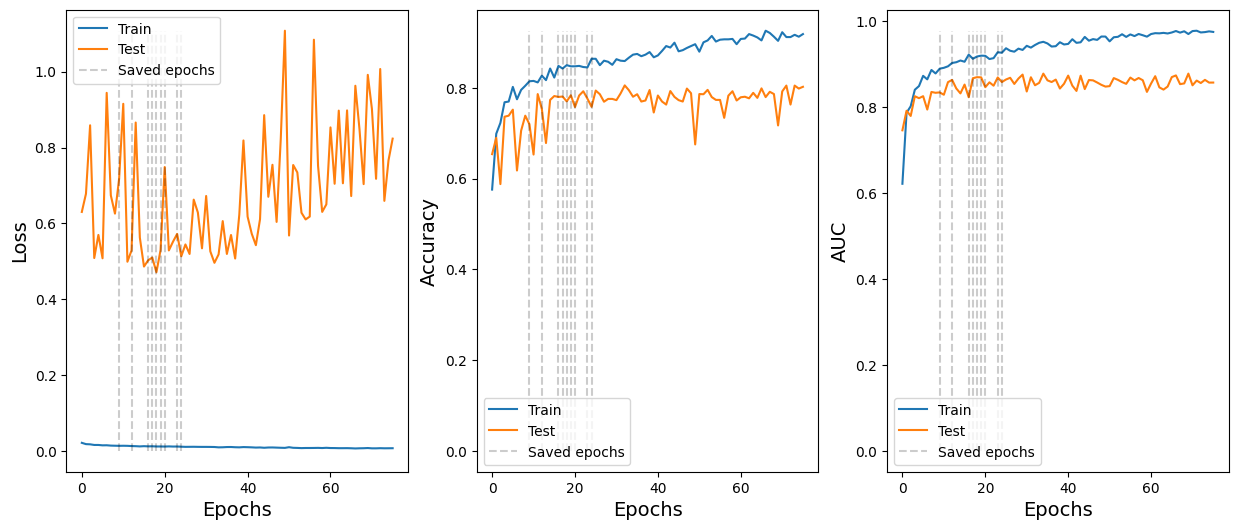

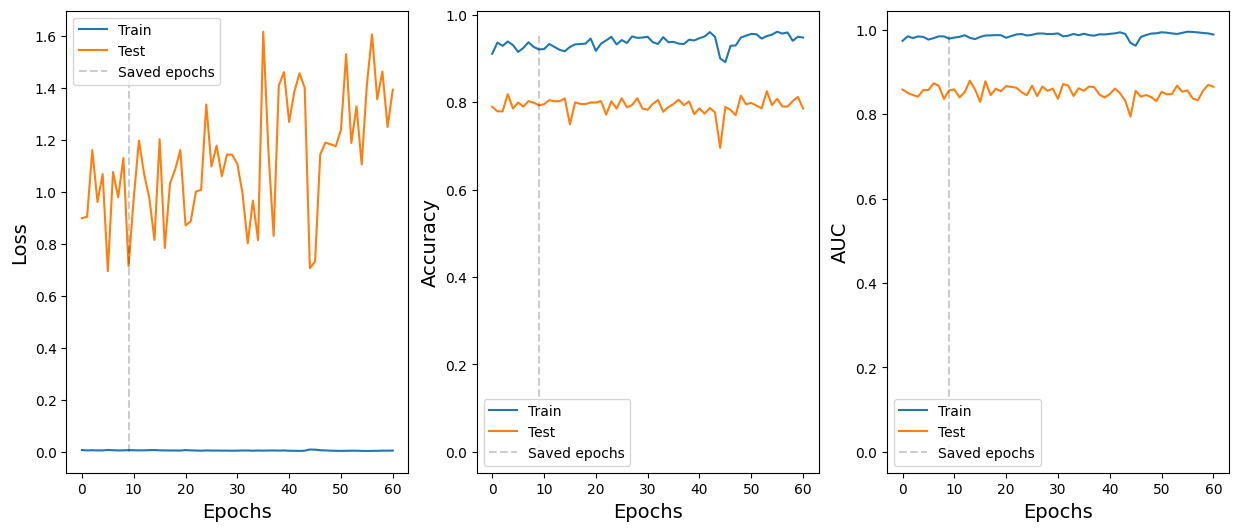

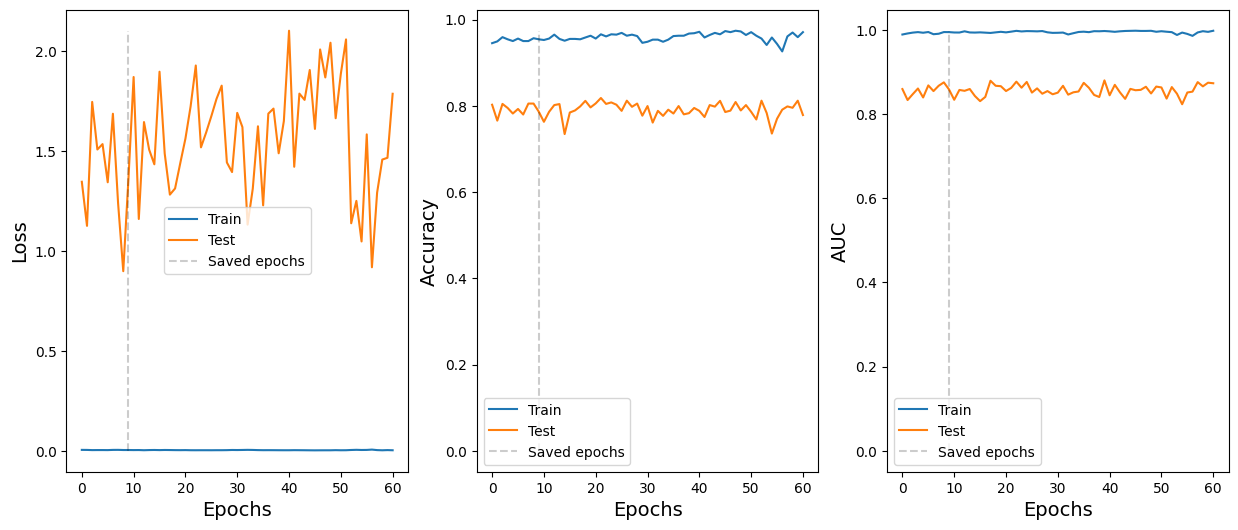

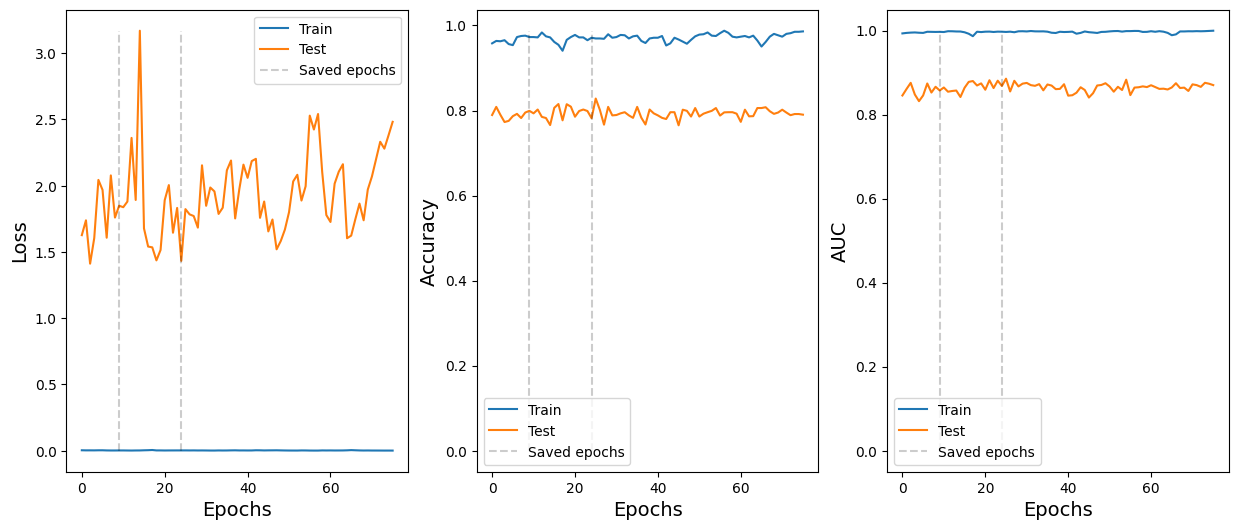

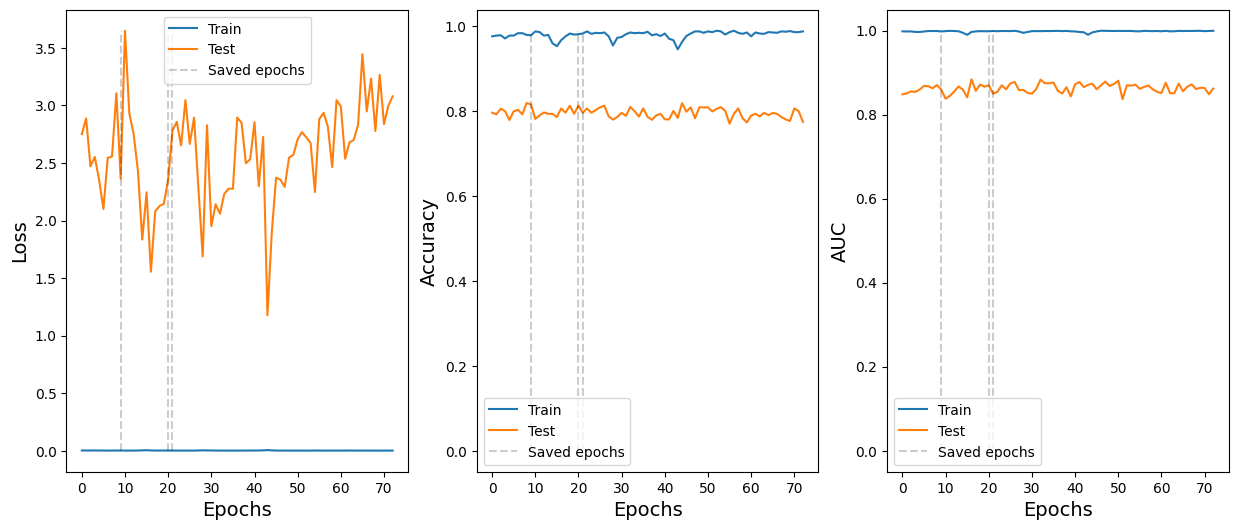

In [62]:
for i in range(0,5):
  print(i)
  with open(f'/content/drive/MyDrive/bace_graph_project/models/gineconv_models/{i}_128_100_global_mean_pool_results.pkl', 'rb') as func:
      loaded_dict = pickle.load(func)

  loss_acc_auc_plots(loaded_dict)

In [ ]:

gat_train_auroc, gat_test_auroc, gat_train_report_df, gat_test_report_df = metric_func(gat_model, train_dataset, test_dataset)
"""
graphconv_train_auroc, graphconv_test_auroc, graphconv_train_report_df, graphconv_test_report_df = metric_func(graphconv_model, train_dataset, test_dataset)

ginconv_train_auroc, ginconv_test_auroc, ginconv_train_report_df, ginconv_test_report_df = metric_func(ginconv_model, train_dataset, test_dataset)
"""
gineconv_train_auroc, gineconv_test_auroc, gineconv_train_report_df, gineconv_test_report_df = metric_func(gineconv_model, train_dataset, test_dataset)



In [ ]:
"""
print("GCN results:")
display("train AUC:", train_auroc, "test AUC:", test_auroc, train_report_df, test_report_df)
"""
print("GAT results:")
display("train AUC:", gat_train_auroc, "test AUC:", gat_test_auroc, gat_train_report_df, gat_test_report_df)
"""
print("GraphConv results:")
display("train AUC:", graphconv_train_auroc, "test AUC:", graphconv_test_auroc, graphconv_train_report_df, graphconv_test_report_df)

print("GinConv results:")
display("train AUC:", ginconv_train_auroc, "test AUC:", ginconv_test_auroc, ginconv_train_report_df, ginconv_test_report_df)
"""
print("GineConv results:")
display("train AUC:", gineconv_train_auroc, "test AUC:", gineconv_test_auroc, gineconv_train_report_df, gineconv_test_report_df)